In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import os

def load_raw(path, name):
    return (
        np.load(os.path.join(path, '{}.npy'.format(name)), encoding='bytes', allow_pickle=True), 
        np.load(os.path.join(path, '{}_labels.npy'.format(name)), encoding='bytes', allow_pickle=True)
    )

In [3]:
# Load Data
tempX, tempY = load_raw("/home/dhruva/idrive/My Stuff/sem8/idc410/assignments/ass3/data", 'dev')

# Assuming 1 Frame - 1 Phonem model

We assume that each phoneme matches to exactly one frame. Hence our first layer should be of `40` length and our last layer should be of length `138`. Further, due to data labels being catagorical, we use the `SparseCategoricalCrossentropy` as the loss function. `ADAM` optimizer was chosen as per usual models. Similarly, `relu` was the activation function for all layers except the last one, which was activated by `softmax`.

The number of layers were chosen by increasing layers and checking if test accuracy was increasing or not. We saw that there is only marginal increase between 2 and 3 layers, so we chose 4 layers to be cautious.

The number of nodes in each layers were chosen randomly, but these can also be optimized over.

In [4]:
# Concat and shuffle all frames
trainX = np.concatenate(tempX)
trainY = np.concatenate(tempY)
args = np.arange(len(trainX))
np.random.shuffle(args)
trainX = trainX[args]
trainY = trainY[args]

In [5]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(270, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(138, activation='softmax'),
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model2.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model2.evaluate(trainX[10000:25000], trainY[10000:25000])

history2 = model2.fit(trainX[:100000], trainY[:100000], epochs=50, verbose=2)

2022-04-29 03:43:53.843816: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-29 03:43:53.844085: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 03:43:53.845328: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-29 03:43:53.917903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-29 03:43:53.933276: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000800000 Hz


469/469 [==============================] - 2s 4ms/step - loss: 9.2496 - accuracy: 0.0077
Epoch 1/50
3125/3125 - 14s - loss: 3.3352 - accuracy: 0.1974
Epoch 2/50
3125/3125 - 16s - loss: 3.0593 - accuracy: 0.2321
Epoch 3/50
3125/3125 - 14s - loss: 2.9766 - accuracy: 0.2447
Epoch 4/50
3125/3125 - 13s - loss: 2.9238 - accuracy: 0.2540
Epoch 5/50
3125/3125 - 14s - loss: 2.8862 - accuracy: 0.2609
Epoch 6/50
3125/3125 - 14s - loss: 2.8534 - accuracy: 0.2661
Epoch 7/50
3125/3125 - 13s - loss: 2.8273 - accuracy: 0.2707
Epoch 8/50
3125/3125 - 16s - loss: 2.8069 - accuracy: 0.2736
Epoch 9/50
3125/3125 - 13s - loss: 2.7860 - accuracy: 0.2793
Epoch 10/50
3125/3125 - 13s - loss: 2.7687 - accuracy: 0.2821
Epoch 11/50
3125/3125 - 13s - loss: 2.7539 - accuracy: 0.2827
Epoch 12/50
3125/3125 - 11s - loss: 2.7413 - accuracy: 0.2856
Epoch 13/50
3125/3125 - 12s - loss: 2.7299 - accuracy: 0.2888
Epoch 14/50
3125/3125 - 15s - loss: 2.7182 - accuracy: 0.2903
Epoch 15/50
3125/3125 - 13s - loss: 2.7087 - accurac

Text(0.5, 1.0, 'Naive model, accuracy vs epoch')

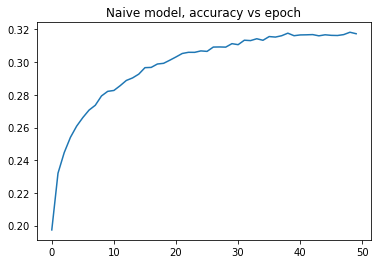

In [6]:
plt.plot(history2.history['accuracy'])
plt.title("Naive model, accuracy vs epoch")

In [7]:
model2.evaluate(trainX[10000:25000], trainY[10000:25000])

469/469 [==============================] - 2s 4ms/step - loss: 2.5441 - accuracy: 0.3265


[2.5441009998321533, 0.3264666795730591]

# Context based model

In this model we assume that adjacent frames also hold some information about the phoneme to be predicted. This seems reasonable as most sounds we make last longer than 10ms, the time length of a single frame. To do this, we now take `i-1`, `i` and `i+1` frames as a single list of 120 elements, and the corresponding phoneme to be the `ith` phoneme.

Further, due to data labels being catagorical, we use the `SparseCategoricalCrossentropy` as the loss function. `ADAM` optimizer was chosen as per usual models. Similarly, `relu` was the activation function for all layers except the last one, which was activated by `softmax`.

The number of layers were chosen by increasing layers and checking if test accuracy was increasing or not. We saw that there is only marginal increase between 2 and 3 layers, so we chose 4 layers to be cautious.

The number of nodes in each layers were chosen randomly, but these can also be optimized over.

In [10]:
trainX_wc = []
trainY_wc = []
for datapoint in range(len(tempX)):
    for frame in range(1, len(tempX[datapoint])-2):
        # for each frame in each datapoint, concat neighbouring frames
        trainX_wc.append(np.concatenate(tempX[datapoint][frame-1:frame+2]))
        trainY_wc.append(tempY[datapoint][frame])
trainX_wc = np.array(trainX_wc)
trainY_wc = np.array(trainY_wc)
args = np.arange(len(trainX_wc))
np.random.shuffle(args)
trainX_wc = trainX_wc[args]
trainY_wc = trainY_wc[args]

In [11]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(180, activation='relu'),
    tf.keras.layers.Dense(270, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(138, activation='softmax'),
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model1.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model1.evaluate(trainX_wc[10000:25000], trainY_wc[10000:25000])

history1 = model1.fit(trainX_wc[:100000], trainY_wc[:100000], epochs=50, verbose=2)

469/469 [==============================] - 2s 4ms/step - loss: 17.2994 - accuracy: 0.0088
Epoch 1/50
3125/3125 - 15s - loss: 3.0628 - accuracy: 0.2535
Epoch 2/50
3125/3125 - 15s - loss: 2.7020 - accuracy: 0.3103
Epoch 3/50
3125/3125 - 14s - loss: 2.6027 - accuracy: 0.3327
Epoch 4/50
3125/3125 - 14s - loss: 2.5394 - accuracy: 0.3433
Epoch 5/50
3125/3125 - 14s - loss: 2.4901 - accuracy: 0.3543
Epoch 6/50
3125/3125 - 13s - loss: 2.4590 - accuracy: 0.3598
Epoch 7/50
3125/3125 - 14s - loss: 2.4375 - accuracy: 0.3653
Epoch 8/50
3125/3125 - 14s - loss: 2.4160 - accuracy: 0.3695
Epoch 9/50
3125/3125 - 14s - loss: 2.3972 - accuracy: 0.3714
Epoch 10/50
3125/3125 - 15s - loss: 2.3780 - accuracy: 0.3776
Epoch 11/50
3125/3125 - 17s - loss: 2.3680 - accuracy: 0.3802
Epoch 12/50
3125/3125 - 18s - loss: 2.3627 - accuracy: 0.3812
Epoch 13/50
3125/3125 - 17s - loss: 2.3439 - accuracy: 0.3849
Epoch 14/50
3125/3125 - 16s - loss: 2.3387 - accuracy: 0.3865
Epoch 15/50
3125/3125 - 14s - loss: 2.3296 - accura

Text(0.5, 1.0, 'Context based model, accuracy vs epoch')

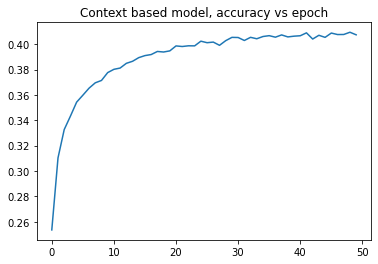

In [12]:
plt.plot(history1.history['accuracy'])
plt.title("Context based model, accuracy vs epoch")

In [13]:
model1.evaluate(trainX_wc[25000:75000], trainY_wc[25000:75000])

1563/1563 [==============================] - 6s 4ms/step - loss: 2.1767 - accuracy: 0.4236


[2.176734209060669, 0.42361998558044434]

# Results

1. Accuracy for Naive model - 32.65%
2. Accuracy for Context based model - 42.36%

From the graph too, we see that the context based model trains to the maximum value faster than the naive model.

Thus, there is a clear advantage to using the context based model over the naive model. Further, the exact amount of context can also be found by running the code for more number of context frames and find the maxima. A maxima will be reached since taking too long a segment may have phoneme overlaps.